# Import Libraries

In this cell, we import the necessary Python libraries and modules required to build and train our deep learning model.  
We use Keras for deep learning, pandas for data manipulation, and other libraries for visualization and metrics evaluation.  
- `ImageDataGenerator`: For data augmentation and preprocessing  
- `Xception`: A pre-trained model for transfer learning  
- `Dense`, `GlobalAveragePooling2D`: For building custom layers  
- `EarlyStopping`: For stopping training once convergence is achieved  
- `confusion_matrix`, `classification_report`: For model evaluation



In [1]:
# --- Import Libraries ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keras modules for model building
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf

# Allow dynamic memory growth on GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Preparation

In this cell, we load and prepare the dataset.  
- We define the data directory path.
- Load class information from a CSV file.
- Filter the dataset to include only the selected art styles: **Impressionism**, **Cubism**, and **Abstract Expressionism**.
- Create a mapping of classes to integer indices (`class_to_index`).
- Define the expected input size for images (**img_width** and **img_height**) that match the input shape required by the Xception model.




In [2]:
# --- Data Preparation ---

# Define the data directory
data_dir = '/kaggle/input/wikiart/'

# Load the class information
class_df = pd.read_csv(os.path.join(data_dir, 'classes.csv'))

# Select three art styles
selected_styles = ['Romanticism', 'Expressionism', 'Post_Impressionism']
class_df = class_df[class_df['genre'].isin(selected_styles)]

# Create a new class-to-index mapping
class_to_index = {style: i for i, style in enumerate(selected_styles)}
num_classes = len(class_to_index)

# Define image dimensions
img_width, img_height = 299, 299  # Xception's expected input size

# Data Augmentation and Generators

In this cell, we set up the data augmentation and create data generators for both the training and validation datasets.

- **Data Augmentation**:
  - Use `ImageDataGenerator` to rescale pixel values and apply random transformations (shearing, zooming, and horizontal flipping) to improve model generalization.
- **Training Generator**:
  - Automatically loads and preprocesses images from the `train` subset of the dataset.
- **Validation Generator**:
  - Similarly, loads and preprocesses images from the `validation` subset.

These generators automatically handle the batching and preprocessing of images for training and validation.



In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.5,
    zoom_range=0.5,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode='categorical',
    classes=list(class_to_index.keys()),
    subset='training',
    shuffle=True,
    seed=42
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode='categorical',
    classes=list(class_to_index.keys()),
    subset='validation',
    shuffle=False
)

Found 16165 images belonging to 3 classes.
Found 4040 images belonging to 3 classes.


# Build the Xception Model (Transfer Learning)

In this cell, we create the deep learning model using transfer learning with the Xception architecture.

- **Load Pre-Trained Model**:
  - Use the Xception model with weights pre-trained on the ImageNet dataset.
  - Exclude the top layers to modify the architecture according to our needs.
  
- **Freeze Layers**:
  - Freeze the base model layers to retain the learned weights from ImageNet training and only train the new top layers.
  
- **Custom Classification Head**:
  - Add a `GlobalAveragePooling2D` layer to reduce the output dimensions.
  - Use the `Dense` layer with a softmax activation function for multi-class classification across the selected art styles.

- **Compile the Model**:
  - Use the Adam optimizer and categorical cross-entropy loss function to train the model.



In [4]:
# --- Build the Xception Model (Transfer Learning) ---

# Load the Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head with Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with an Adam optimizer
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks to Improve Training ---

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train the Model

In this cell, we train the deep learning model using the training dataset while evaluating it on the validation dataset.

- **Training Configuration**:
  - Train the model for **10 epochs**.
  - Use the `fit()` method with both the `train_generator` and `validation_generator`.
  - Keras automatically handles the training and validation data fetching in batches.

- The early stopping callback ensures training stops once the validation loss no longer decreases, helping prevent overfitting.



In [5]:
# --- Train the Model ---

# Train the model with the callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734375150.756467      89 service.cc:145] XLA service 0x7a40a0438990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734375150.756531      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-16 18:52:40.719891: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[64,256,74,74]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,74,74]{3,2,1,0}, f32[256,256,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_

253/253 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - accuracy: 0.4056 - loss: 1.0900 - val_accuracy: 0.5208 - val_loss: 0.9827 - learning_rate: 1.0000e-04
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.5738 - loss: 0.9213 - val_accuracy: 0.5696 - val_loss: 0.9306 - learning_rate: 1.0000e-04
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 676s 3s/step - accuracy: 0.6109 - loss: 0.8604 - val_accuracy: 0.5785 - val_loss: 0.9069 - learning_rate: 1.0000e-04
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 658s 3s/step - accuracy: 0.6284 - loss: 0.8222 - val_accuracy: 0.5901 - val_loss: 0.8862 - learning_rate: 1.0000e-04
Epoch 5/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.6446 - loss: 0.8007 - val_accuracy: 0.5963 - val_loss: 0.8784 - learning_rate: 1.0000e-04
Epoch 6/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - accuracy: 0.6515 - loss: 0.7780 - val_accuracy: 0.5973 - val_loss: 0.8767 - learning_rate: 1.0000e-04
Epoch 7/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 649s 3s/step - accuracy: 0.65

# Model Evaluation and Metrics Analysis

## Step 1: Predict and Prepare Metrics
In this step, we make predictions using the trained model on the validation dataset.  
The predicted classes are extracted from the model's softmax outputs, and the true classes are retrieved for comparison.  
We also print a small sample of the true and predicted labels to confirm the data's structure. it may improve.



In [6]:
# Predict the classes on the validation dataset
validation_generator.reset()  # Ensure we start from the beginning of data
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(class_to_index.keys())

# Print true class labels
print(f"True Classes: {true_classes[:10]}")
print(f"Predicted Classes: {predicted_classes[:10]}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step
True Classes: [0 0 0 0 0 0 0 0 0 0]
Predicted Classes: [2 2 0 0 2 2 0 0 0 2]


## Step 2: Confusion Matrix and Classification Report
This step computes the confusion matrix and the classification report to evaluate the model's performance.  
The confusion matrix provides a detailed breakdown of true vs. predicted labels, while the classification report shows precision, recall, and F1-score for each class.

We also plot the confusion matrix as a heatmap for better visualization.

Classification Report:
                    precision    recall  f1-score   support

       Romanticism       0.67      0.72      0.69      1403
     Expressionism       0.63      0.61      0.62      1347
Post_Impressionism       0.58      0.55      0.57      1290

          accuracy                           0.63      4040
         macro avg       0.63      0.63      0.62      4040
      weighted avg       0.63      0.63      0.63      4040



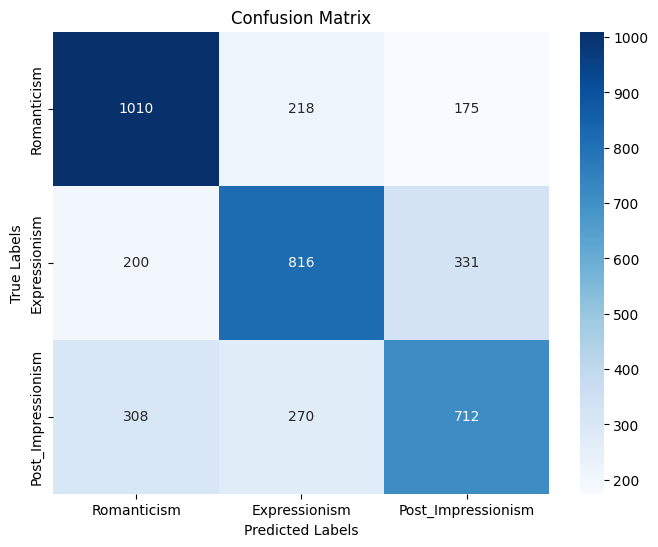

In [7]:
# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Step 3: Calculate ROC and AUC for Each Class
Here, we calculate the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) for each class.  
The ROC curve is a graphical representation of the model's ability to distinguish between classes, while the AUC quantifies this performance.

In [8]:
# Calculate ROC and AUC for each class
num_classes = len(class_labels)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print("ROC AUC Scores for each class:")
for i, label in enumerate(class_labels):
    print(f"{label}: AUC = {roc_auc[i]:.2f}")

ROC AUC Scores for each class:
Romanticism: AUC = 0.85
Expressionism: AUC = 0.81
Post_Impressionism: AUC = 0.76


## Step 4: Macro-Averaged AUC Calculation
In this step, we compute the macro-averaged AUC, which gives an overall performance score across all classes.  
This is achieved by averaging the true positive rates (TPR) for all classes.

In [9]:
# Calculate macro AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes
macro_auc = auc(all_fpr, mean_tpr)

print(f"Macro-Averaged AUC: {macro_auc:.2f}")

Macro-Averaged AUC: 0.81


## Step 5: Plot ROC Curves
Finally, we plot the ROC curves for all individual classes along with the macro-averaged ROC curve.  
This visualization helps understand the performance of each class and the overall model in distinguishing between categories.

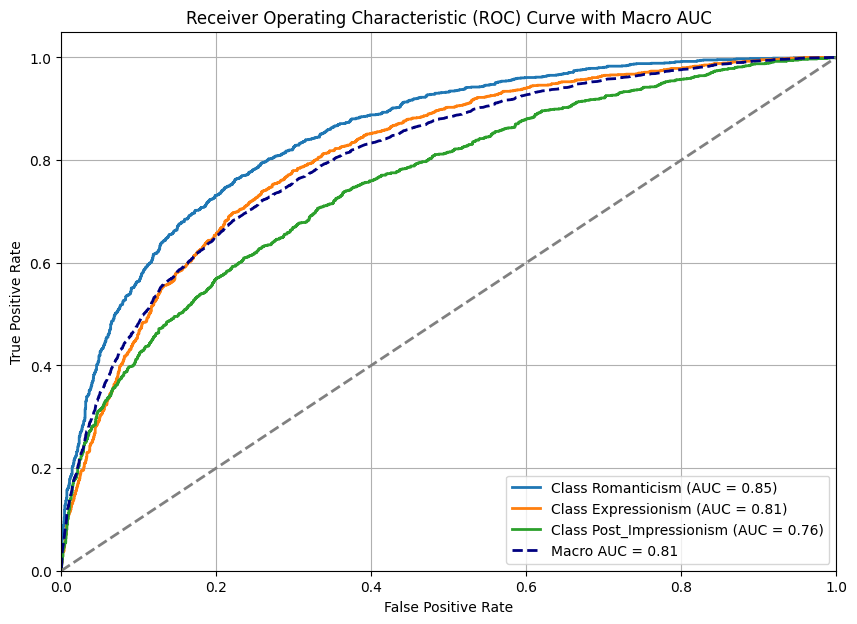

In [10]:
# Plot ROC Curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Add the macro-average AUC curve
plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--', lw=2, label=f'Macro AUC = {macro_auc:.2f}')

plt.plot([0, 1], [0, 1], '--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Macro AUC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [11]:
model.save('xception.h5')  # Save the model to an HDF5 file